# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

- Stakeholder - Literally anyone
- Business problem:
    - Random city in random state is ordering Covid vaccines and is fully aware that not everyone will get the vaccine. Random city wants to know how many Covid vaccines they should be ordering.
- Target: H1N1
- Cost of different errors FP/FN
- False Positive: Model predicts they will get the vaccine, but didn't.
- Ordering too many vaccines and wasting money/material
- False Negative: Model predicts they won't get the vaccine, but did.
- Vaccine shortage. Loss of life.
- Metric:
  - Recall
  - F1-score

In [1]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import category_encoders as ce

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [3]:
features_df = pd.read_csv('Data/training_set_features.csv')
lables_df = pd.read_csv('Data/training_set_labels.csv')

In [4]:
lables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [5]:
# code here to explore your data

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [6]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
features_df.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [8]:
features_df.drop(columns=['respondent_id','health_insurance', 'employment_industry', 'employment_occupation'], inplace= True)

In [9]:
X = features_df
y = lables_df['h1n1_vaccine']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42
)

In [11]:
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [12]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [13]:
ohe_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

In [14]:
freq_cols

['hhs_geo_region']

In [15]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [16]:
num_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [18]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', '...
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['age_group', 'education', 'race', 'sex',
           

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## 1. Logistic Regression

### 1.1 Baseline Model

In [22]:
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [23]:
cross_validate(lr_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([0.29527116, 0.30627298, 0.29827189, 0.29325914, 0.28426003]),
 'score_time': array([0.02101731, 0.02301908, 0.02201962, 0.02202249, 0.02001691]),
 'test_score': array([0.83235541, 0.83598771, 0.83263481, 0.83202907, 0.83398547]),
 'train_score': array([0.83680313, 0.83519631, 0.83512645, 0.83478868, 0.83527768])}

In [24]:
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [25]:
lr_preds = lr_clf.predict(X_val)

In [26]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, lr_preds)))
print('recall {:0.3f}'.format(recall_score(y_val, lr_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , lr_preds)))

accuracy: 0.837
recall: 0.420
f1: 0.523
roc_auc: 0.685


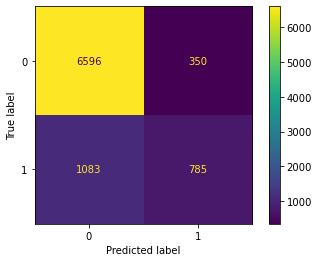

In [27]:
plot_confusion_matrix(lr_clf, X_val, y_val)

### 1.2 Iteration

In [28]:
params={'classifier__penalty':['l2', 'l1','elasticnet'],
        'classifier__C':[ 0.1, 1, 10, 100, 101, 102,103,104,105]
       }

In [29]:
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='f1')
output = grid_clf.fit(X_train, y_train)

In [30]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

Best Param:{'classifier__C': 103, 'classifier__penalty': 'l2'}, Best f1:0.517


### 1.3 Model 2.0

In [31]:
output.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [32]:
val_preds = output.best_estimator_.predict(X_val)

In [33]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, val_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, val_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, val_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , val_preds)))

accuracy: 0.838
recall: 0.423
f1: 0.525
roc_auc: 0.686


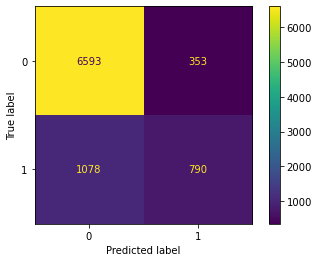

In [34]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val)

### 1.4 ROC Curve

In [35]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

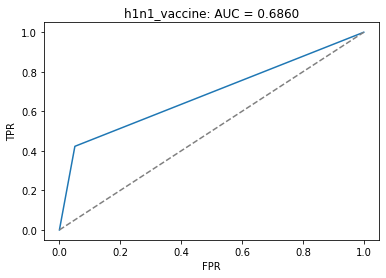

In [36]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    val_preds, 
    'h1n1_vaccine',
    ax = ax
)

In [75]:
X_pre = preprocessor.fit_transform(X_train)
X_pre

array([[0.33333333, 1.        , 0.        , ..., 0.        , 1.        ,
        0.10853406],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.10478958],
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.11831442],
       ...,
       [0.66666667, 0.5       , 0.        , ..., 0.        , 1.        ,
        0.11831442],
       [0.66666667, 0.5       , 0.        , ..., 1.        , 0.        ,
        0.10736042],
       [1.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.12245012]])

In [77]:
importance = output.best_estimator_['classifier'].coef_[0]
#for feat, importance in zip(X_pre, output.best_estimator_['classifier'].coef_[0]):
#    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.33250
Feature: 1, Score: 0.33404
Feature: 2, Score: 0.18449
Feature: 3, Score: -0.07556
Feature: 4, Score: 0.22901
Feature: 5, Score: 0.01343
Feature: 6, Score: -0.21704
Feature: 7, Score: -0.10537
Feature: 8, Score: 0.08068
Feature: 9, Score: 1.99684
Feature: 10, Score: -0.43072
Feature: 11, Score: 0.12171
Feature: 12, Score: 0.22204
Feature: 13, Score: 0.77393
Feature: 14, Score: 2.50440
Feature: 15, Score: 1.51235
Feature: 16, Score: -0.08030
Feature: 17, Score: 0.44327
Feature: 18, Score: 0.57517
Feature: 19, Score: -0.32398
Feature: 20, Score: -0.08103
Feature: 21, Score: -0.13635
Feature: 22, Score: -0.36245
Feature: 23, Score: -0.41549
Feature: 24, Score: -0.36991
Feature: 25, Score: -0.17405
Feature: 26, Score: 0.04998
Feature: 27, Score: -0.29470
Feature: 28, Score: -0.49443
Feature: 29, Score: -0.17174
Feature: 30, Score: -0.27456
Feature: 31, Score: -0.03648
Feature: 32, Score: -0.55558
Feature: 33, Score: -0.33944
Feature: 34, Score: -0.10209
Feature: 

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17893 entries, 11702 to 23654
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 17835 non-null  float64
 1   h1n1_knowledge               17813 non-null  float64
 2   behavioral_antiviral_meds    17846 non-null  float64
 3   behavioral_avoidance         17753 non-null  float64
 4   behavioral_face_mask         17879 non-null  float64
 5   behavioral_wash_hands        17860 non-null  float64
 6   behavioral_large_gatherings  17832 non-null  float64
 7   behavioral_outside_home      17842 non-null  float64
 8   behavioral_touch_face        17813 non-null  float64
 9   doctor_recc_h1n1             16427 non-null  float64
 10  doctor_recc_seasonal         16427 non-null  float64
 11  chronic_med_condition        17255 non-null  float64
 12  child_under_6_months         17358 non-null  float64
 13  health_worke

From feature importance, we realized feature 9, 14, 15 has high impact coefficient. Based on our encoded dataset:
- 9 => doctor_recc_h1n1
- 14 => opinion_h1n1_vacc_effective
- 15 => opinion_h1n1_risk

Feature 55 has lowest coefficient (high coeff in absolute value).
- 55 => household_children

In [38]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
11702,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,oxchjgsf,Non-MSA,1.0,0.0
967,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Other or Multiple,Female,Below Poverty,Not Married,Rent,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0
5547,3.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Not Principle City",0.0,0.0
19590,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Female,"> $75,000",Married,Own,Employed,fpwskwrf,"MSA, Not Principle City",1.0,2.0
15939,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Female,"> $75,000",Married,Rent,Employed,atmpeygn,"MSA, Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Male,"> $75,000",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0
5390,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,mlyzmhmf,"MSA, Principle City",0.0,0.0
860,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,Non-MSA,1.0,0.0
15795,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Black,Female,"> $75,000",Married,Own,Employed,kbazzjca,"MSA, Principle City",1.0,0.0


## 2. Naive Bayesian

### 2.1 Baseline Model

In [39]:
from sklearn.naive_bayes import GaussianNB

In [40]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [41]:
cross_validate(nb_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([0.11910844, 0.11010766, 0.11610579, 0.1151042 , 0.11411023]),
 'score_time': array([0.02402186, 0.0240221 , 0.02402186, 0.02902675, 0.02401423]),
 'test_score': array([0.76194468, 0.76334172, 0.75970942, 0.75768586, 0.76495249]),
 'train_score': array([0.76170183, 0.76016487, 0.76428671, 0.76213762, 0.76800559])}

In [42]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [43]:
nb_preds = nb_clf.predict(X_val)

In [44]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds)))

accuracy: 0.768
recall: 0.628
f1: 0.535
roc_auc: 0.717


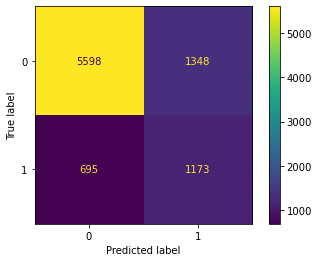

In [45]:
plot_confusion_matrix(nb_clf, X_val, y_val)

### 2.2 Tuning

In [46]:
params={'classifier__var_smoothing':np.logspace(0,-9, num=100),
       }

In [47]:
grid_nb = GridSearchCV(nb_clf, param_grid=params, scoring='f1')
output_nb = grid_nb.fit(X_train, y_train)

In [48]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_nb.best_params_, 
                                                  grid_nb.best_score_))

Best Param:{'classifier__var_smoothing': 0.1}, Best f1:0.541


### 2.2 Model 2.0

In [49]:
output_nb.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [50]:
nb_preds2 = output_nb.best_estimator_.predict(X_val)

In [51]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds2)))

accuracy: 0.788
recall: 0.602
f1: 0.547
roc_auc: 0.720


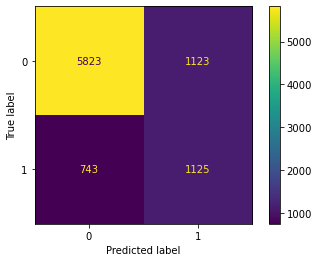

In [52]:
plot_confusion_matrix(output_nb.best_estimator_, X_val, y_val)

### 2.4 ROC Curve

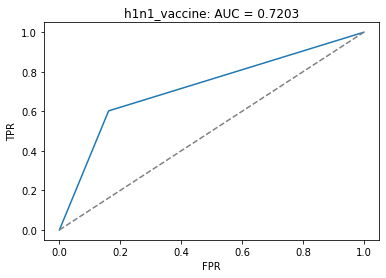

In [53]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    nb_preds2, 
    'h1n1_vaccine',
    ax = ax
)

## 3. KNN

## 3.1 Baseline Model

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [56]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                 

In [57]:
knn_preds = knn_clf.predict(X_val)

In [58]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds)))

accuracy: 0.798
recall: 0.246
f1: 0.340
roc_auc: 0.596


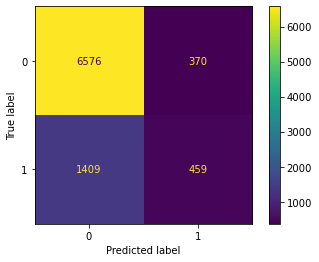

In [59]:
plot_confusion_matrix(knn_clf, X_val, y_val)

### 3.2 Tuning

In [60]:
#params={'classifier__n_neighbors':list(range(1,5)),
#        'classifier__weights':["uniform", "distance"],
#        'classifier__metric' : ['euclidean', 'manhattan', 'minkowski']
#       }

In [61]:
#grid_knn = GridSearchCV(knn_clf, param_grid=params, scoring='f1')
#output_knn = grid_knn.fit(X_train, y_train)

In [62]:
#print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_knn.best_params_, 
                                                  grid_knn.best_score_))

IndentationError: unexpected indent (<ipython-input-62-9f294a2d5e56>, line 2)

### 3.3 Model 2.0 

In [ ]:
#output_knn.best_estimator_.fit(X_train, y_train)

In [ ]:
#knn_preds2 = output_knn.best_estimator_.predict(X_val)

In [ ]:
#print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds2)))
#print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds2)))
#print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds2)))
#print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds2)))

In [ ]:
#plot_confusion_matrix(output_knn.best_estimator_, X_val, y_val)

### 3.4 ROC Curve

In [ ]:
#fig, ax = plt.subplots()
#plot_roc(
#    y_val, 
#    knn_preds2, 
#    'h1n1_vaccine',
#    ax = ax
#)

# 4. Stack?

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier())
])

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [ ]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
